In [ ]:
%matplotlib inline

import pygama.lh5 as lh5
import matplotlib.pyplot as plt
import numpy as np
import glob
from matplotlib.colors import LogNorm
import pathlib
from iminuit import cost,Minuit
from scipy.special import erf, erfc
from scipy.stats import norm, poisson
from scipy.integrate import simps

In [ ]:
import os,json
import math
from scipy.optimize import curve_fit
import pygama.analysis.histograms as pgh
import pygama.analysis.calibration as cal
import pygama.analysis.peak_fitting as pgp
import pygama.analysis.peak_fitting as pgf
import scipy.optimize as opt
import matplotlib.colors as mcolors
import matplotlib.cm as cmx
from scipy.integrate import quad
from matplotlib.lines import Line2D
from matplotlib.backends.backend_pdf import PdfPages
import numba as nb
from math import erfc
from iminuit import Minuit, cost
from iminuit.util import propagate
import sys

%matplotlib inline
import pygama.io.lh5 as lh5
from pygama.dsp.WaveformBrowser import WaveformBrowser
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, json

# Set defaults for figures
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 16

In [ ]:
kwd = {"parallel": False, "fastmath": True}
limit = np.log(sys.float_info.max)/10

# A/E PDFs fit definition

In [4]:
def PDF_AoE(x, lambda_s, lambda_b, gaussian_mean, gaussian_sigma, htail,htau):
    
    pdf = (lambda_b * gauss_tail_norm(x,gaussian_mean, gaussian_sigma,htail,htau)+\lambda_s * norm_pdf(x, gaussian_mean, gaussian_sigma))
    #(1./(lambda_s+lambda_b))*
    return lambda_s+lambda_b, pdf

In [5]:
@nb.njit(**kwd)
def norm_pdf(x, mu, sigma):
    if sigma ==0: invs=np.nan
    else: invs = 1.0 / sigma
    z = (x - mu) * invs
    invnorm = 1 / np.sqrt(2 * np.pi) * invs
    return np.exp(-0.5 * z ** 2) * invnorm

In [6]:
@nb.njit(**kwd)
def nb_erf(x):
    y = np.empty_like(x)
    for i in nb.prange(len(x)):
        y[i] = erfc(x[i])
    return y

#@nb.njit(**kwd)
def gauss_tail(x, mu, sigma, tail, tau):
    """
    A gaussian tail function template
    Can be used as a component of other fit functions
    """
    x = np.asarray(x)
    tmp = ((x-mu)/tau) + ((sigma**2)/(2*tau**2))
    tail_f = np.where(tmp < limit, gauss_tail_exact(x, mu, sigma, tail, tau), gauss_tail_approx(x, mu, sigma, tail, tau))
    return tail_f

#@nb.njit(**kwd)
def gauss_tail_exact(x, mu, sigma, tail, tau):
    tmp = ((x-mu)/tau) + ((sigma**2)/(2*tau**2))
    abstau = np.absolute(tau)
    tmp = np.where(tmp < limit, tmp, limit)
    z = (x-mu)/sigma
    tail_f = (tail/(2*abstau)) * np.exp(tmp) * nb_erf( (tau*z + sigma)/(np.sqrt(2)*abstau))
    return tail_f

@nb.njit(**kwd)
def gauss_tail_approx(x, mu, sigma, tail, tau):
    den = 1/(sigma + tau*(x-mu)/sigma)
    tail_f = tail * sigma * norm_pdf(x, mu, sigma) * den * (1.-tau*tau*den*den)
    return tail_f

def gauss_tail_norm(x,mu, sigma, htail, tau):
    xs = np.linspace(np.nanmin(x), np.nanmax(x), 10001)#
    try:
        norm_pdf_values = gauss_tail(xs, mu, sigma, htail, tau)
    except ZeroDivisionError: 
        return 0
    normalisation = simps(norm_pdf_values, xs, axis = 0)
    exp_part = gauss_tail(x, mu, sigma, htail, tau)
    return exp_part / normalisation

In [7]:
@nb.njit(**kwd)
def fexpo(x,p1,p2):
    return np.exp(p1+x*p2)

def norm_fexpo(x,z,p1,p2):
    xs = np.linspace(np.nanmin(x), np.nanmax(x), 10001)
    norm_pdf_values = fexpo(xs, p1,p2)
    normalisation = simps(norm_pdf_values, xs, axis = 0)

    return z*fexpo(x,p1,p2)/normalisation

# Energy PDFs

In [8]:
@nb.njit(**kwd)
def step_pdf(x,  mu, sigma, hstep):
    invs = (np.sqrt(2)*sigma)
    z = (x-mu)/invs
    step_f = 1 + hstep * nb_erf(z)
    return step_f

In [9]:
def peak_pdf(x, mu, sigma, htail, tau):
    peak = norm_pdf(x,mu,sigma)
    tail = gauss_tail(x, mu, sigma, htail, tau)
    return peak+tail

In [10]:
def norm_energy_pdf(x, pdf_func, *params):
    xs = np.arange(np.nanmin(x), np.nanmax(x), 0.01)
    norm_pdf_values = pdf_func(xs, *params)
    normalisation = simps(norm_pdf_values, xs, axis = 0)

    return pdf_func(x, *params)/normalisation

In [11]:
def radford_pdf(data, lambda_s, lambda_b, mu, sigma, hstep, htail, tau):
    pdf = (lambda_b * norm_energy_pdf(data, step_pdf, mu, sigma, hstep) +\lambda_s *  norm_energy_pdf(data, peak_pdf, mu, sigma, htail, tau))
    
    return lambda_s+lambda_b, pdf

# A/E fit

In [12]:
def unbinned_aoe_fit(aoe, display=0, verbose=False):
    aoe_len = len(aoe)
    hist, bins,var = pgh.get_hist(aoe,bins=500)
    bin_centers = (bins[:-1]+bins[1:])/2
    
    pars, cov = pgf.gauss_mode_max(hist, bins, var)
    mu = bin_centers[np.argmax(hist)]
    amp = np.amax(hist)

    sigma=pgh.get_fwhm(hist, bins)[0]/2.355
    
    ls_guess = 2*np.sum(hist[(bin_centers>mu)&(bin_centers<(mu+2.5*sigma))])
    def gauss(x,z,mu,sigma):
        return z * norm.pdf(x,mu,sigma)
    c1_min= mu-2*sigma #0.495
    c1_max= mu+5*sigma #0.52
    c1 = cost.UnbinnedNLL(aoe[(aoe<c1_max)&(aoe>c1_min)], gauss)
    m1 = Minuit(c1, ls_guess, mu,sigma)
    m1.limits = [(0, len(aoe[(aoe<c1_max)&(aoe>c1_min)])),(mu*0.8, mu*1.2),(0.8*sigma,sigma*1.2)]
    m1.migrad()
    ls_guess =m1.values[0]
    mu = m1.values[1]
    sigma = m1.values[2]

    fmin=  mu-15*sigma #0.45
    fmax = mu+5*sigma #0.52
    c2_max = mu-4*sigma

    c2 = cost.UnbinnedNLL(aoe[(aoe<c2_max)&(aoe>fmin)], norm_fexpo)
    m2 = Minuit(c2, len(aoe[(aoe<c2_max)&(aoe>fmin)]), -20,10)
    m2.limits=[(0,len(aoe[(aoe<c2_max)&(aoe>fmin)])),(-100,0),(0,20)]
    m2.migrad()
    f = m2.values[2]

    pars = [mu,sigma,amp,0,f,10]
    
    bg_guess = len(aoe[(aoe<fmax)&(aoe>fmin)])-ls_guess
    x0 = [ls_guess,bg_guess,pars[0],pars[1],pars[4],pars[5]]
    if verbose:print(x0)
        
    c = cost.ExtendedUnbinnedNLL(aoe[(aoe<fmax)&(aoe>fmin)], PDF_AoE)

    m = Minuit(c, *x0)

    m.migrad()
    m.hesse()
    if verbose:print(m.values)
    if display>1:
        plt.figure()
        xs = np.linspace(fmin,fmax,1000)
        counts, bins, bars = plt.hist(aoe[(aoe<fmax)&(aoe>fmin)], bins=400, histtype='step')
        dx = np.diff(bins)
        plt.plot(xs, PDF_AoE(xs,*m.values)[1]* dx[0], label="Total PDF")
        #plt.yscale('log')
        plt.plot(xs , (m.values[1])*gauss_tail_norm(xs,*m.values[2:])* dx[0], label="Tail PDF")
        plt.plot(xs , (m.values[0])*norm_pdf(xs,*m.values[2:4])*dx[0], label="Gaussian PDF")
        plt.legend(loc='upper left')
        plt.title("Fit Components")
        plt.show()
        
        plt.figure()
        bin_centers= (bins[1:]+bins[:-1])/2
        plt.plot(bin_centers, (PDF_AoE(bin_centers,*m.values)[1] * dx[0]) - counts)
        plt.title("Residuals")
        plt.show()
        return m.values, m.errors
    else: return m.values, m.errors

In [13]:
def AoEcorrection(e,aoe,eres, display=1, plot_all=False):
    


    comptBands_width = 20;
    comptBands = np.array([940,960,980,1000,1020,1040,1130,1150,
                           1170,1190,1210,1250,1270,1290,
                         1310,1330,1370,1390,1420,1540,1650,1700,
                           1780,1810,1850,1870,1890,1910,1930,1950,
                         1970,1990,2010,2030,2050,2150,2170,2190
                           ,2210,2230,2250,2270,2290])
    comptBands = comptBands[::-1]
    peaks = np.array([1080,1094,1459,1512, 1552, 1592,1620,
                      1650, 1670,1830,2105]) 
    compt_aoe = np.zeros(len(comptBands))
    aoe_sigmas = np.zeros(len(comptBands))
    compt_aoe_err = np.zeros(len(comptBands))
    aoe_sigmas_err = np.zeros(len(comptBands))
    ratio = np.zeros(len(comptBands))
    ratio_err = np.zeros(len(comptBands))
    
    copper = cm = plt.get_cmap('copper') 
    cNorm  = mcolors.Normalize(vmin=0, vmax=len(comptBands))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=copper)
    
    plt.figure()
    for i, band in enumerate(comptBands):
        aoe_tmp = aoe[(e>band) & (e<band+comptBands_width) & (aoe>0)][:10000]
  
        hist, bins,var = pgh.get_hist(aoe_tmp,bins=500)
        bin_center = (bins[:-1] + bins[1:]) / 2
        pars,errs = unbinned_aoe_fit(aoe_tmp, display=display)
        compt_aoe[i] = pars[2]
        aoe_sigmas[i] = pars[3]
        compt_aoe_err[i] = errs[2]
        aoe_sigmas_err[i] = errs[3]
        ratio[i] = pars[0]/pars[1]
        ratio_err[i] = ratio[i]*np.sqrt((errs[0]/pars[0])**2 + (errs[1]/pars[1])**2)
        xs = np.arange(pars[2]-4*pars[3], pars[2]+3*pars[3],pars[3]/10)
        if np.isnan(errs[2])|np.isnan(errs[3])|(errs[2]==0)|(errs[3]==0): pass
        else:
            colorVal = scalarMap.to_rgba(i)
            plt.plot(xs,PDF_AoE(xs, *pars)[1], color = colorVal)
    def pol1(x,a,b):
        return a * x + b
    plt.xlabel('A/E')
    plt.ylabel("Expected Counts")
    plt.title("Compton Band Fits")
    cbar = plt.colorbar(cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('copper_r')), orientation='horizontal', label='Compton Band Energy', ticks=[0,16,32,len(comptBands)])
    cbar.ax.set_xticklabels([comptBands[::-1][0],comptBands[::-1][16],comptBands[::-1][32],comptBands[::-1][-1]])
    plt.show()
    
    
    
    ids = np.isnan(compt_aoe_err)|np.isnan(aoe_sigmas_err)|(aoe_sigmas_err==0)|(compt_aoe_err==0)

    plt.figure()
    plt.errorbar(comptBands[~ids], ratio[~ids], xerr=10,yerr = ratio_err[~ids], linestyle=' ')
    plt.xlabel("Energy (keV)")
    plt.ylabel("N_sig/N_bkg")
    plt.show()
    
    
    pars, cov = opt.curve_fit(pol1,comptBands[~ids],compt_aoe[~ids],sigma= compt_aoe_err[~ids], absolute_sigma=True)
    errs = np.sqrt(np.diag(cov))

    sig_pars, sig_cov = opt.curve_fit(pol1,comptBands[~ids],
                                      aoe_sigmas[~ids],
                                      sigma = aoe_sigmas_err[~ids], 
                                      absolute_sigma=True)
    sig_errs = np.sqrt(np.diag(sig_cov))

    def sigma_fit(x, a,b,c):
        return np.sqrt(a+(b/x)**c)
    
    p0 = [0.001,10, 3]
    c = cost.LeastSquares(comptBands[~ids],aoe_sigmas[~ids],
                          aoe_sigmas_err[~ids], sigma_fit)

    #print(p0)
    c.loss = "soft_l1"
    m = Minuit(c, *p0)
    m.migrad()
    m.hesse()

    sig_pars2 = m.values
    sig_errs2 = m.errors

    model = pol1(comptBands,*pars)
    sig_model = pol1(comptBands,*sig_pars)
    sig_model2 = sigma_fit(comptBands,*sig_pars2)
    
    sigma = np.sqrt(eres[0]+1592*eres[1])/2.355
    n_sigma = 4
    peak = 1592
    emin           = peak - n_sigma*sigma
    emax           = peak + n_sigma*sigma
    dep_pars, dep_err = unbinned_aoe_fit(aoe[(e>emin) 
                                             & (e<emax) & (aoe>0)])

    fig, (ax1, ax2) = plt.subplots(2, 1, 
                                   constrained_layout=True, sharex=True)
    ax1.errorbar(comptBands[~ids]+10,compt_aoe[~ids],yerr=compt_aoe_err[~ids], xerr=10,label='data', linestyle= ' ')
    ax1.plot(comptBands[~ids]+10,model[~ids],label='linear model')
    ax1.errorbar(1592, dep_pars[2], xerr = n_sigma*sigma, yerr = dep_err[2], label='DEP', color='green', linestyle= ' ')
        
    ax1.legend(title='A/E mu energy dependence', frameon=False)
        
    ax1.set_ylabel("raw A/E (a.u.)", ha='right', y=1)
    #ax1.ylim([np.amax(model), np.amin(model)])
    ax2.scatter(comptBands[~ids]+10,100*(compt_aoe[~ids]-model[~ids])/model[~ids], lw=1, c='b')
    ax2.scatter(1592,100*(dep_pars[2]-pol1(1592,*pars))/pol1(1592,*pars), lw=1, c='g')
    ax2.set_ylabel("Residuals %", ha='right', y=1)
    ax2.set_xlabel("Energy (keV)", ha='right', x=1)
    plt.show()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True, sharex=True)
    ax1.errorbar(comptBands[~ids]+10, aoe_sigmas[~ids],yerr= aoe_sigmas_err[~ids],xerr = 10, label='data', linestyle= ' ')
    #ax1.plot(comptBands[~ids],sig_model[~ids],label='linear model')
    ax1.plot(comptBands[~ids],sig_model2[~ids],label=f'sqrt model: sqrt({sig_pars2[0]:1.4f}+({sig_pars2[1]:1.1f}/E)^{sig_pars2[2]:1.1f})')
    ax1.errorbar(1592, dep_pars[3], xerr = n_sigma*sigma,yerr = dep_err[3], label='DEP', color='green')
    ax1.set_ylabel("A/E stdev (a.u.)", ha='right', y=1)
    ax1.legend(title='A/E stdev energy dependence', frameon=False)
    ax2.scatter(comptBands[~ids]+10,100*(aoe_sigmas[~ids]-sig_model2[~ids])/sig_model2[~ids], lw=1, c='b')
    ax2.scatter(1592,100*(dep_pars[3]-sigma_fit(1592,*sig_pars2))/sigma_fit(1592,*sig_pars2), lw=1, c='g')
    ax2.set_ylabel("Residuals %", ha='right', y=1)
    ax2.set_xlabel("Energy (keV)", ha='right', x=1)
    plt.show()


    return pars, sig_pars2, comptBands[~ids], aoe_sigmas[~ids], aoe_sigmas_err[~ids]

## Energy fit

In [14]:
def unbinned_energy_fit(energy, peak, fwhm):
    energy_len = len(energy)
    hist, bins,var = pgh.get_hist(energy,dx=0.1, range= (np.amin(energy), np.amax(energy)))
    sigma = fwhm/2.355
    bg0 = np.sum(hist[-5:])/5
    step = np.sum(hist[:5])/5 - bg0
    htail = 1./5
    tau = 6.*sigma

    # now compute amp and return
    height = np.amax(hist)
    height -= (bg0 + step/2)
    amp = height / (htail*0.87/35 + (1-htail)/(sigma*np.sqrt(2*np.pi)))
    hstep = step/(2*amp)
    guess = [peak, sigma, hstep, htail, tau, bg0, amp]
    
    x0 = [guess[-1]*guess[1]*10,energy_len-(guess[-1]*guess[1]*10),*guess]
    x0= x0[:-2]
    bounds = [(0,energy_len),(0,energy_len), (x0[2]-2*x0[3], x0[2]+2*x0[3]), (0, x0[3]*2), (0, 1), (0, 1), (x0[3], 100*x0[3])] 
    c = cost.ExtendedUnbinnedNLL(energy, radford_pdf)
    m = Minuit(c, *x0)
    m.limits = bounds
    m.migrad()
    m.hesse()

    return m.values, m.errors

In [15]:
def overlap(data1,data2):
    '''
    Calculates overlap between two histogram datasets
    '''
    
    diff = abs(data1-data2)
    overlap = 0
    
    for i in range(0,len(diff)):
        if (diff[i]!= max(data1[i],data2[i])):
            overlap = overlap + min(data1[i],data2[i])
    
    return overlap

def histogram_bins(tp_max,tp_min,width):
    '''
    Calculates histogram bins
    '''
    
    a = 0
    
    for i in range(0,4):
        atest = max(tp_max[i]-tp_min[i])
        
        if atest>a+2500:
            pass
            
        elif atest>a:
            a=atest
        
    if a == 0:
        a=3000

    return np.arange(0,a+width,width)

# Load in Data

In [16]:
energy_params = ['cuspEmax', 'cuspEmax_ctc', 'A_max','dt_eff']

In [17]:
det      = ['V05612A','V05612B','V05267A','V04199A']
D=2
det = det[D]
datatype = 'th_HS2_lat_psa'
run = '001'
energy_param = energy_params[1]

In [18]:
datapath   = f'/unix/legend/shared/test_data/{det}/tier2/{datatype}'
files      = os.listdir(datapath)
files.sort()
for i,file in enumerate(files):
    files[i] = os.path.join(datapath,file)
files = files[0:10]

datapath1   = f'/unix/legend/shared/test_data/{det}/tier1/{datatype}'
raw_files      = os.listdir(datapath1)
raw_files.sort()
for i,raw_file in enumerate(raw_files):
    raw_files[i] = os.path.join(datapath1,raw_file)

In [19]:
calpath = f'/unix/legend/shared/aoe/{det}.json'

with open(calpath, 'r') as o:
    cal_dict = json.load(o)
cal_pars = cal_dict[energy_param]['Calibration_pars']
eres_pars = [cal_dict[energy_param]['m0'], cal_dict[energy_param]['m1']]
adc = cal_pars[0]

In [20]:
print(len(files),'files found in',datapath)
uncal_pass = lh5.load_nda(files,energy_params,'raw',verbose=False)
print("done")

10 files found in /unix/legend/shared/test_data/V05267A/tier2/th_HS2_lat_psa
done


In [21]:
ecal_pass = pgp.poly(uncal_pass[energy_param], cal_pars)

In [22]:
curr = uncal_pass['A_max']
aoe = np.divide(curr,pgp.poly(uncal_pass['cuspEmax'], cal_pars))

## Drift time plots

In [23]:
def plot_dt_dep(aoe, energy,dt, erange,title):
    
    hist, bins,var = pgh.get_hist(aoe[(energy>erange[0]) &(energy<erange[1])],bins=500)
    bin_cs = (bins[1:]+bins[:-1])/2
    mu = bin_cs[np.argmax(hist)]
    aoe_range = [mu*0.9, mu*1.1]
    
    idxs = (energy>erange[0]) &(energy<erange[1])&(aoe>aoe_range[0])&(aoe<aoe_range[1])&(dt<2000)
    plt.hist2d(aoe[idxs], dt[idxs], bins=[200,100], norm=LogNorm())
    plt.ylabel('Drift Time (ns)')
    plt.xlabel('A/E')
    plt.title(title)
    
def plot_dt_dep_aoe(aoe, energy,dt, erange,title):
    
    hist, bins,var = pgh.get_hist(aoe[(energy>erange[0]) 
                                      &(energy<erange[1])],bins=500)
    bin_cs = (bins[1:]+bins[:-1])/2
    mu = bin_cs[np.argmax(hist)]
    aoe_range = [mu*0.9, mu*1.1]
    
    idxs = (energy>erange[0]) &(energy<erange[1])&(aoe>aoe_range[0])
                                    &(aoe<aoe_range[1])&(dt<2000)
    plt.hist2d(aoe[idxs], dt[idxs], bins=[200,100], norm=LogNorm())
    plt.ylabel('Drift Time (ns)')
    plt.xlabel('A/E')
    plt.title(title)
    return aoe_range

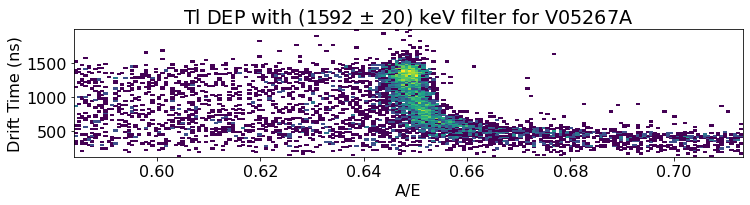

In [24]:
dt = uncal_pass["dt_eff"]
plt.figure()
plt.subplot(3,1,1)
plot_dt_dep(aoe, ecal_pass, dt, [1572,1612], f'Tl DEP with (1592 $\pm$ 20) keV filter for {det}')

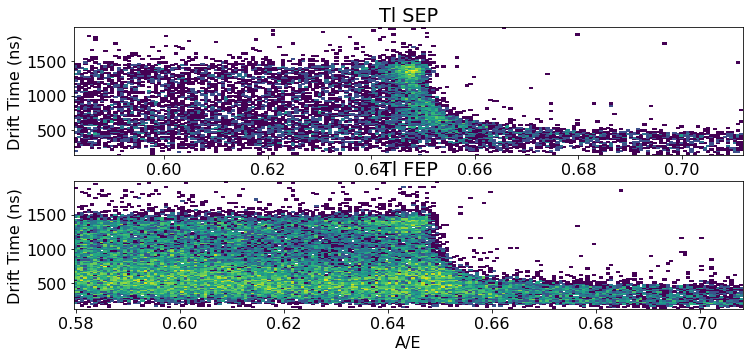

In [25]:
plt.figure
plt.subplot(3,1,2)
plot_dt_dep(aoe, ecal_pass, dt, [2070,2130], f'Tl SEP')
plt.subplot(3,1,3)
plot_dt_dep(aoe, ecal_pass, dt, [2550,2670], f'Tl FEP')
plt.show()

## Waveform Selector:

In [26]:
# First, load a dataframe from a DSP file that we can use to make our selection:
df = lh5.load_dfs(files, ['cuspEmax_ctc' , 'A_max', 'dt_eff', 
                          'tp_0_est', 'tp_01', 'tp_10', 'tp_20', 
                          'tp_50', 'tp_80','tp_90', 'tp_95', 'tp_99', 
                          'tp_max'], '/raw')
trapE = df['cuspEmax_ctc']
tp_0 = df['tp_0_est']
tp_01 = df['tp_01']
tp_10 = df['tp_10']
tp_20 = df['tp_20']
tp_50 = df['tp_50']
tp_80 = df['tp_80']
tp_90 = df['tp_90']
tp_95 = df['tp_95']
tp_99 = df['tp_99']
tp_max = df['tp_max']
dt_eff = df['dt_eff']


tps_ = [tp_0,tp_01,tp_10,tp_20,tp_50,tp_80,tp_90,tp_95,tp_99,tp_max]

cal_E = trapE*adc

loading data for /unix/legend/shared/test_data/V05267A/tier2/th_HS2_lat_psa/char_data-V05267A-th_HS2_lat_psa-run0001-201006T161531_tier2.lh5 /unix/legend/shared/test_data/V05267A/tier2/th_HS2_lat_psa/char_data-V05267A-th_HS2_lat_psa-run0001-201006T162532_tier2.lh5 /unix/legend/shared/test_data/V05267A/tier2/th_HS2_lat_psa/char_data-V05267A-th_HS2_lat_psa-run0001-201006T163534_tier2.lh5 /unix/legend/shared/test_data/V05267A/tier2/th_HS2_lat_psa/char_data-V05267A-th_HS2_lat_psa-run0001-201006T164535_tier2.lh5 /unix/legend/shared/test_data/V05267A/tier2/th_HS2_lat_psa/char_data-V05267A-th_HS2_lat_psa-run0001-201006T165539_tier2.lh5 /unix/legend/shared/test_data/V05267A/tier2/th_HS2_lat_psa/char_data-V05267A-th_HS2_lat_psa-run0001-201006T170542_tier2.lh5 /unix/legend/shared/test_data/V05267A/tier2/th_HS2_lat_psa/char_data-V05267A-th_HS2_lat_psa-run0001-201006T171544_tier2.lh5 /unix/legend/shared/test_data/V05267A/tier2/th_HS2_lat_psa/char_data-V05267A-th_HS2_lat_psa-run0001-201006T172547_t

In [27]:
# DEP range to be analysed
E_DEP = 1592
pm = 3
DEP_range = [(E_DEP-pm)/adc, (E_DEP+pm)/adc]
DEP_range_cal = [(E_DEP-pm), (E_DEP+pm)]

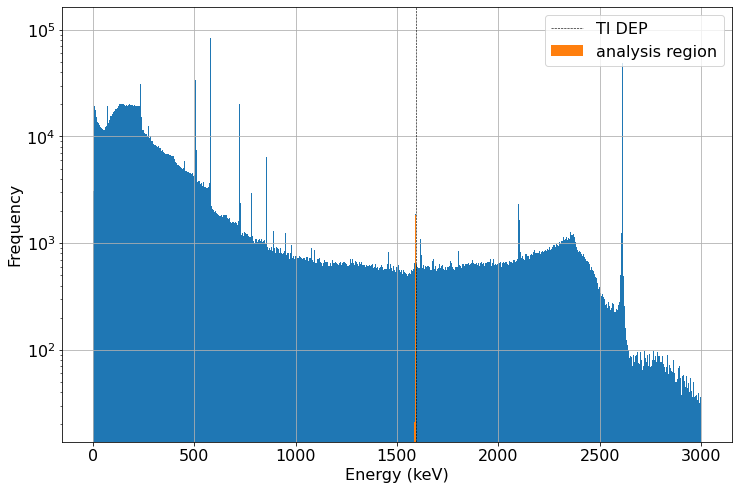

In [28]:
# Plots energy spectrum of detector with region of analysis about DEP
energy_selection_cal = (ecal_pass>DEP_range_cal[0]) & (ecal_pass<DEP_range_cal[1])

cal_E.hist(bins=1000, range=(0, 3000))
cal_E[energy_selection_cal].hist(bins=1000, range=(0, 3000), 
                                 label='analysis region')
plt.axvline(x=E_DEP, ls = '--', color = 'k', lw = '0.6', 
                                    label = 'Tl DEP')
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel('Energy (keV)')
plt.ylabel('Frequency')
#plt.title(f"Energy spectrum and analysis region for {det}")

plt.savefig(f'figures/E_Spectrum_{det}.jpg', dpi = 400)

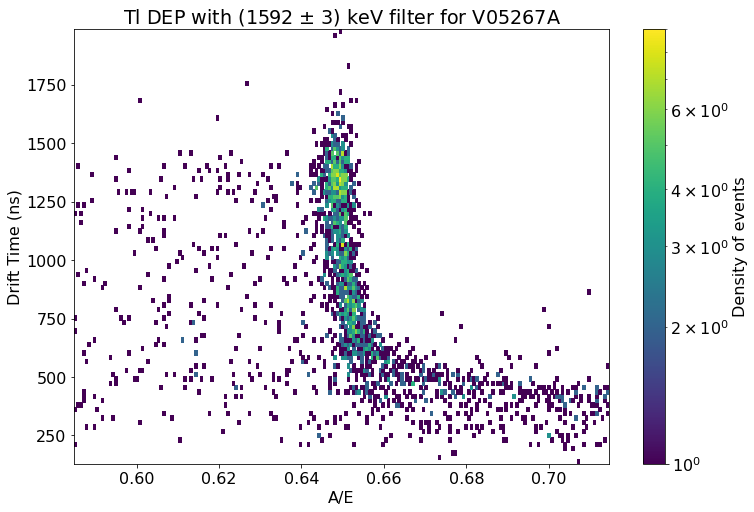

In [29]:
# Raw drift time plot for analysed detector
plt.figure()
aoe_range = plot_dt_dep_aoe(aoe, ecal_pass, dt, DEP_range_cal, f'Tl DEP with ({E_DEP} $\pm$ {pm}) keV 'filter for {det}')
plt.xlim(min(aoe_range), max(aoe_range))
plt.colorbar(label = 'Density of events')
plt.savefig(f'dt_plot_{det}', dpi = 400);

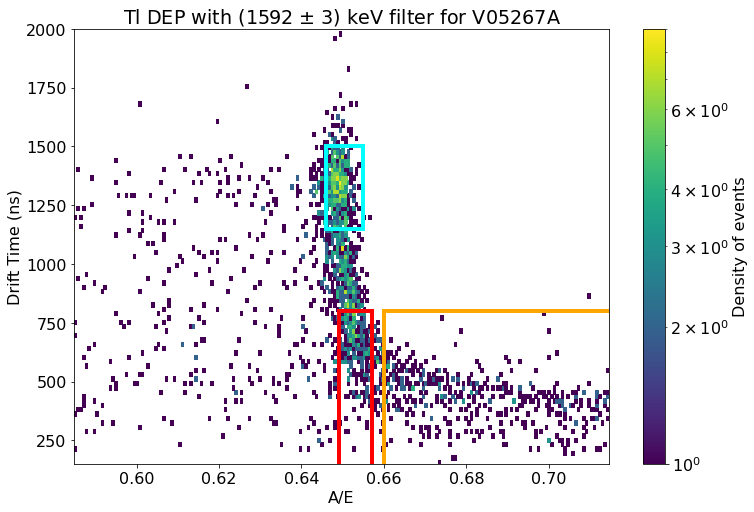

In [30]:
# Drift time plot with region of analyses
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
# [red,magenta,orange,cyan]
aoe_low = [[0.659,0.656,0.67,0.656],[0.883,0.88,0.9,0.9],[0.649,0.646,0.66,0.646]]
aoe_high = [[0.667,0.667,0.8,0.667],[0.893,0.893,0.96,0.96],[0.657,0.655,0.8,0.655]]
aoe_low = aoe_low[D]
aoe_high = aoe_high[D]

dtime_low = [[100,1150,100,1150],[300,1000,300,1000],[100,1150,100,1150]]
dtime_high = [[800,1400,800,1400],[500,1300,500,1300],[800,1500,800,1500]]
dtime_low = dtime_low[D]
dtime_high= dtime_high[D]

aoe_selection = []
dtime_selection = []
rect = []
colour = ['red','magenta','orange','cyan']

plt.figure()
aoe_range = plot_dt_dep_aoe(aoe, ecal_pass, dt, DEP_range_cal,f'Tl DEP with ({E_DEP} $\pm$ {pm}) keV 'filter for {det}')
plt.xlim(min(aoe_range), max(aoe_range))
plt.colorbar(label = 'Density of events')
plt.ylim(150,2000)

for i in range(0,4):   
    aoe_selection.append((aoe>aoe_low[i]) & (aoe<aoe_high[i]))
    dtime_selection.append((dt>dtime_low[i]) & (dt<dtime_high[i]))
    plt.gca().add_patch(plt.Rectangle((aoe_low[i],dtime_low[i]), aoe_high[i]-aoe_low[i], dtime_high[i]-dtime_low[i], ec=colour[i], fc='none', lw=4))
    
plt.savefig(f'figures/dt_aoe_{det}.jpg', dpi = 400)

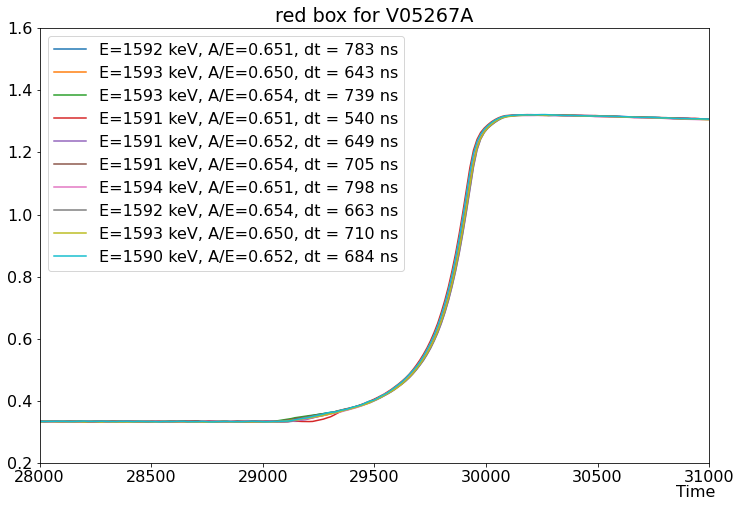

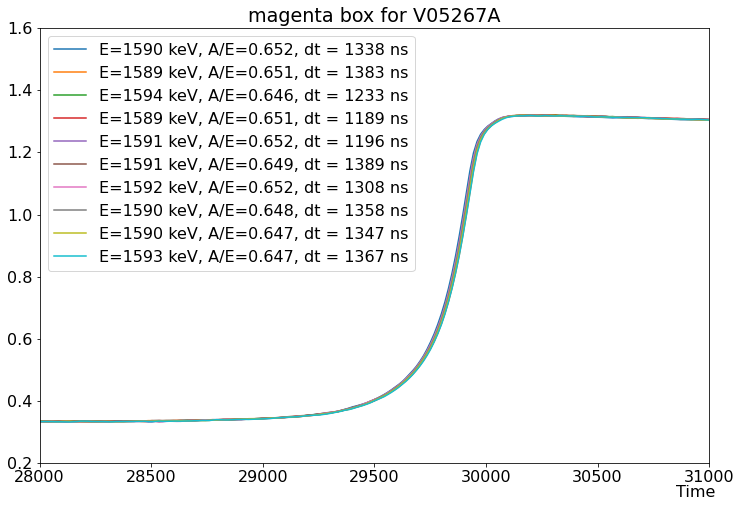

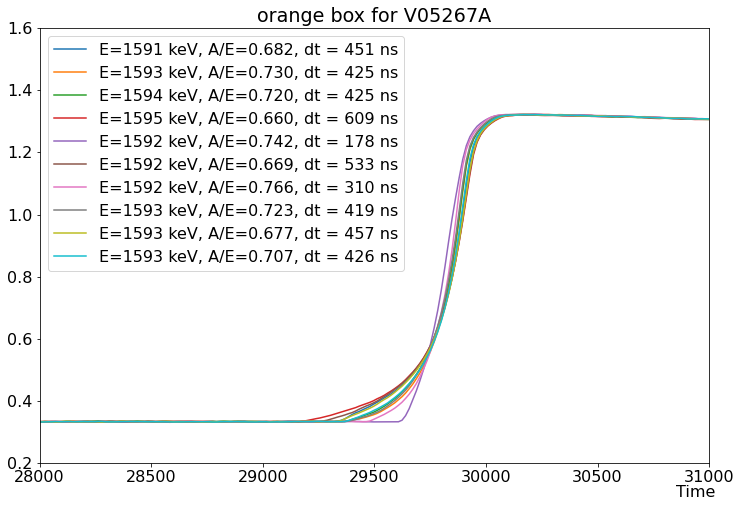

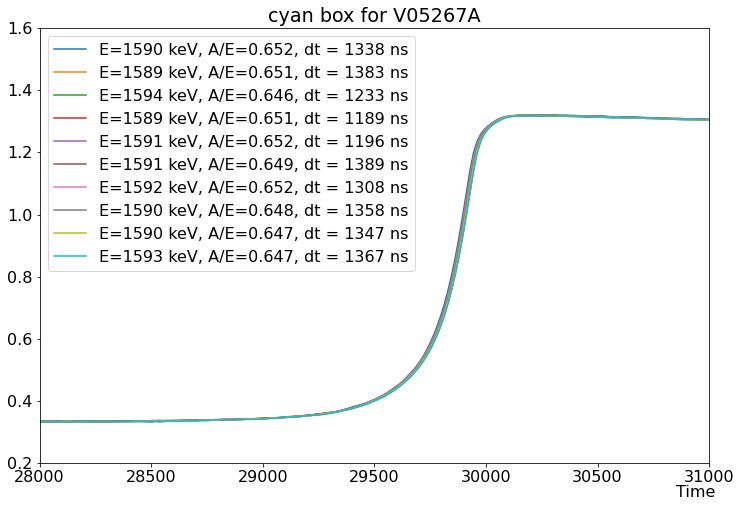

In [31]:
# Extracts waveforms from analysis regions using the LEGEND waveform browser
browser = []
axis = [[28500,31000,10000,34000],[28000,30500,14000,38000],[28000,31000,5000,30000]]
axis_norm = [[28500,31000,0.6,1.8],[28000,30500,0.6,1.8],[28000,31000,0.2,1.6]]

for i in range(0,4):
    browser.append(WaveformBrowser(raw_files, '/raw',verbosity   = 0,                
                               legend      = ("E={:.0f} keV, 
                                              'A/E={:.3f}, dt = {:.0f} ns'
                                              , ecal_pass, aoe, dt),
                                   
                               selection   = energy_selection_cal 
                                       & aoe_selection[i] 
                                        & dtime_selection[i],        
                               norm = trapE, 
                               n_drawn     = 10                  
                              ))

    browser[i].draw_next()
    plt.title(f'{colour[i]} box for {det}')
    plt.xlabel('Time')
    plt.ylabel('')
    plt.axis(axis_norm[D])
    plt.savefig(f'figures/{colour[i]}_box_{det}.jpg', dpi = 400)

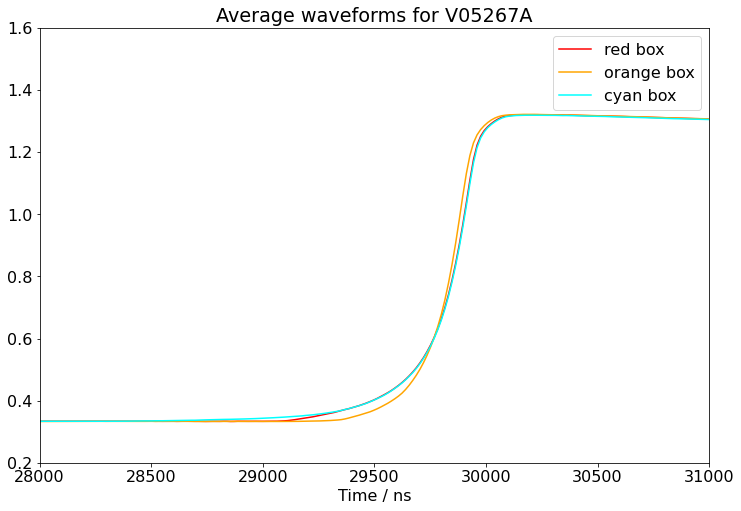

In [32]:
# Plots average waveforms from each analysis region into one plot

if D == 1: # If detector = V05612B
    for j in range(0,4):
        y = []

        for i in range(0,10):
            y.append(browser[j].wf_data[0][i][1])

        y_avg = sum(y)/len(y)
        x = browser[j].wf_data[0][0][0]

        plt.plot(x,y_avg,color = colour[j], label = f'{colour[j]} box')
        plt.xlabel('Time / ns')
        plt.title(f'Average waveforms for {det}')
        plt.legend(loc='best')
        plt.axis(axis_norm[D])
        plt.savefig(f'figures/Avg_waveform_{det}.jpg', dpi = 400)
        
else:
    for j in [0,2,3]:
        y = []

        for i in range(0,10):
            y.append(browser[j].wf_data[0][i][1])

        y_avg = sum(y)/len(y)
        x = browser[j].wf_data[0][0][0]

        plt.plot(x,y_avg,color = colour[j], label = f'{colour[j]} box')
        plt.xlabel('Time / ns')
        plt.title(f'Average waveforms for {det}')
        plt.legend(loc='best')
        plt.axis(axis_norm[D])
        plt.savefig(f'figures/Avg_waveform_{det}.jpg', dpi = 400)

In [33]:
# Extracts timepoint data for analysis regions
t0 = []
t1 = []
t10 = []
t20 = []
t50 = []
t80 = []
t90 = []
t95 = []
t99 = []
tmax = []

for i in range(0,4):
    selection   = energy_selection_cal & aoe_selection[i] & dtime_selection[i]
    t0.append(tp_0[selection])
    t1.append(tp_01[selection])
    t10.append(tp_10[selection])
    t20.append(tp_20[selection])
    t50.append(tp_50[selection])
    t80.append(tp_80[selection])
    t90.append(tp_90[selection])
    t95.append(tp_95[selection])
    t99.append(tp_99[selection])
    tmax.append(tp_max[selection])

## Overlap Method:

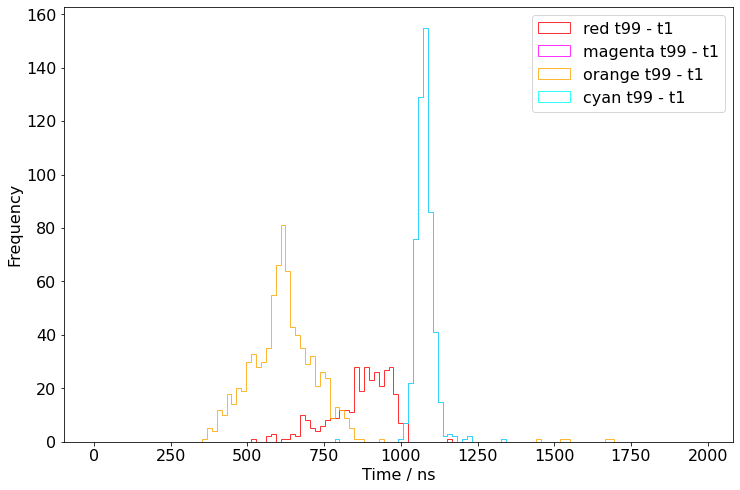

In [34]:
# Calculates and plots timepoint distributions with minimal overlap

tps = [t0,t1,t10,t20,t50,t80,t90,t95,t99,tmax]
tps_id = ['t0','t1','t10','t20','t50','t80','t90','t95','t99','tmax']

tps_reverse = reversed(tps)
overlap_value = 1000
width = 16
overlap_matrix = np.empty((len(tps),len(tps)))
overlap_matrixp = np.empty((len(tps),len(tps)))

for i in range(0,int(len(tps))):
    tps_reversed = next(tps_reverse)
    for j in range(0,len(tps) - (i+1)): # Iterates through each possible 
                                        # timepoint difference of |Y-X|
        
        Itest = len(tps) - (i+1)
        Jtest = j
        
        p_test = []
        difference_test = []
        n_test = []
        bin0 = histogram_bins(tps_reversed,tps[j],width)
        
        for k in range(0,4):
            difference_test.append(abs(tps_reversed[k] - tps[j][k]))
            n_t, binstest = np.histogram(difference_test[k], bins = bin0)
            n_test.append(n_t)
        
        # Calculates overlap, as in Equation (9)
        overlap_test = overlap(n_test[0],n_test[2])+overlap(n_test[1],n_test[2])
        
        red = difference_test[0]
        cyan = difference_test[1]
        orange = difference_test[2]
        overlap_matrix[Itest][Jtest] = overlap_matrix[Jtest][Itest] = overlap_test
        overlap_matrixp[Itest][Jtest] = overlap_matrixp[Jtest][Itest] = 100*(overlap_test/(len(red)+len(cyan)+len(orange)))
        
        if (overlap_test < overlap_value): # If overlap decreases,
                                            # updates index I and J, 
                                                # and overlap values
            overlap_value = overlap_test
            difference = difference_test
            I = len(tps) - (i+1)
            J = j

for i in range(0,len(tps)):
    overlap_matrix[i][i] = overlap_matrix.max()
    overlap_matrixp[i][i] = 100

bin0 = histogram_bins(tps[I],tps[J],width)

for X in np.arange(0,1000,5):
    test = difference[0]
    if (100*len(test[test>X])/len(test) < 90):
        break
    time_cut = X

n = []
cut_values = []
tphist_values = []

plt.figure()
for i in range(0,4):
    diff = difference[i]
    cut_values.append(100*len(diff[diff>time_cut])/len(diff))
    bin0 = np.arange(0,2000,16)
    ntest, binstest, patchestest = plt.hist(diff, bins = bin0, 
                                            histtype='step', alpha=0.8, 
                                            edgecolor = colour[i], 
                                            label = f'{colour[i]} 
                                            {tps_id[I]} - {tps_id[J]}', 
                                            color = colour[i])
    tphist_values.append(ntest)
    plt.xlabel('Time / ns')
    plt.ylabel('Frequency')
    n.append(ntest)

plt.legend(loc='best');
plt.savefig(f'figures/tp_hist_{det}.jpg', dpi = 400)

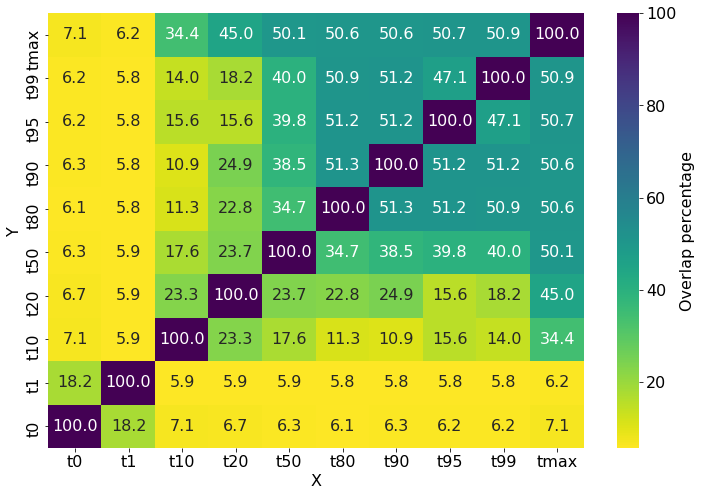

In [35]:
# Plots parameter space of timepoint distributions |Y-X| 
# with an 'overlap percentage' figure of merit

import seaborn as sns
axesticks = [tps_id[i] for i in range(0,10)]
plt.figure()
sns.heatmap(overlap_matrixp[:len(tps),:len(tps)], annot = True, fmt = '.1f', cmap = 'viridis_r', cbar = True, xticklabels=axesticks, yticklabels=axesticks, cbar_kws={'label': 'Overlap percentage'})
plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')
#plt.title(f'percentage of overlap |Y - X| events for {det}');
plt.savefig(f'figures/Overlap_matrix_per{det}.jpg', dpi = 400)

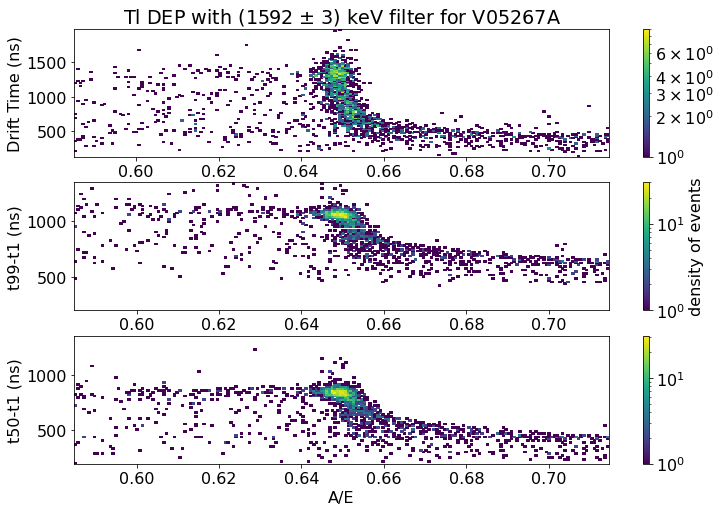

In [36]:
# Drift time plot, with optimal timepoint difference and t50-t1 plots

plt.figure()
plt.subplot(3,1,1)
aoe_range = plot_dt_dep_aoe(aoe, ecal_pass, dt_eff, DEP_range_cal, f'Tl DEP with ({E_DEP} $\pm$ {pm}) keV 'filter for {det}')
plt.colorbar()

plt.subplot(3,1,2)
plot_dt_dep(aoe, ecal_pass, (tps_[I]-tps_[J]), DEP_range_cal, f'')
plt.ylabel(f'{tps_id[I]}-{tps_id[J]} (ns)')
plt.xlim(min(aoe_range),max(aoe_range))
plt.ylim(200,1350)
plt.colorbar(label = 'density of events');

plt.subplot(3,1,3)
delta = 4
plot_dt_dep(aoe, ecal_pass, (tps_[I-delta]-tps_[J]), DEP_range_cal, f'')
plt.ylabel(f'{tps_id[I-delta]}-{tps_id[J]} (ns)')
plt.xlim(min(aoe_range),max(aoe_range))
plt.ylim(200,1350)
plt.colorbar();

plt.savefig(f'figures/dt_aoe_cut_{det}.jpg', dpi = 400)

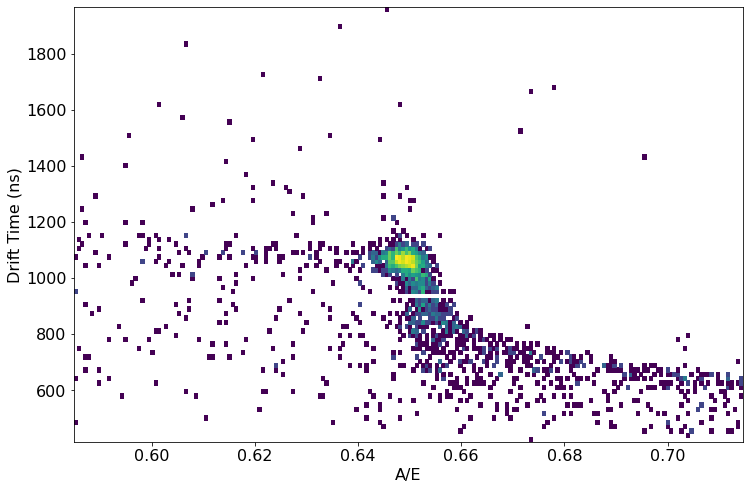

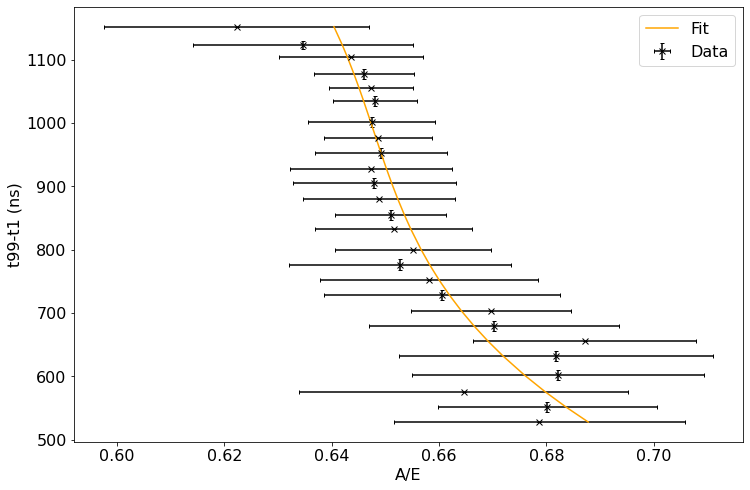

In [37]:
# Plots median A/E values for selected 25 ns drift time bands

aoe_range = plot_dt_dep_aoe(aoe, ecal_pass, (tps_[I]-tps_[J]), DEP_range_cal, f'')
dts_range = (tps_[I]-tps_[J])[energy_selection_cal&(aoe>aoe_range[0])&(aoe<aoe_range[1])&((tps_[I]-tps_[J])<2000)]
dts = (tps_[I]-tps_[J])[energy_selection_cal&(aoe>aoe_range[0])&(aoe<aoe_range[1])&((tps_[I]-tps_[J])<1200)]
aoe1 = aoe[energy_selection_cal&(aoe>aoe_range[0])&(aoe<aoe_range[1])&((tps_[I]-tps_[J])<1200)]
bands = np.arange(min(dts),max(dts),25)

aoe_means = []
dt_means = []
aoe_stds = []
dt_stds = []

for i in range(0,len(bands)-1):
    aoe_band = []
    aoe_band = aoe1[(dts>bands[i])&(dts<bands[i+1])]
    dt_band = dts[(dts>bands[i])&(dts<bands[i+1])]
    aoe_means.append(np.mean(aoe_band))
    dt_means.append(np.mean(dt_band))
    aoe_stds.append(np.std(aoe_band))
    dt_stds.append(np.std(dt_band))

plt.figure()
a = 4
plt.errorbar(aoe_means[a:], dt_means[a:], fmt = 'x', color = 'k', yerr = dt_stds[a:], xerr = aoe_stds[a:], label = 'Data', capsize = 2)

w = []
for i in range(a,len(aoe_stds)):
    w.append(1/aoe_stds[i])
    
b = np.polyfit(dt_means[a:], aoe_means[a:], w = w, deg = 3)
y = []
for dtm in dt_means[a:]:
    y.append(b[3] + b[2]*dtm + b[1]*dtm**2 + b[0]*dtm**3)

plt.plot(y,dt_means[a:], color = 'orange', label = 'Fit')
plt.xlabel('A/E')
plt.ylabel(f'{tps_id[I]}-{tps_id[J]} (ns)')
plt.legend(loc='best')
#plt.savefig(f'dt aoe fit {tps_id[I]}-{tps_id[J]} {det}.jpg', dpi = 400);

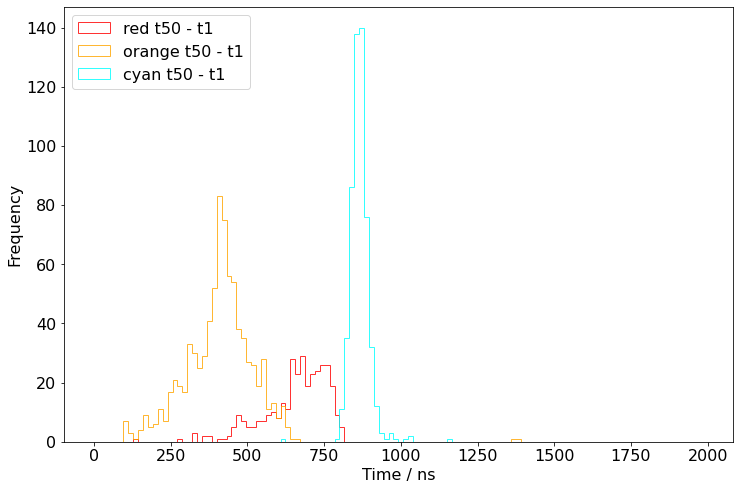

In [38]:
# Plots t50 - t1 for analysed detector

plt.figure()
for i in [0,2,3]:
    diff = t50[i]-t1[i]
    bin0 = np.arange(0,2000,16)
    ntest, binstest, patchestest = plt.hist(diff, bins = bin0, 
                                            histtype='step', alpha=0.8, 
                                            edgecolor = colour[i], 
                                            label = f'{colour[i]} 
                                            {tps_id[len(tps)-6]} - 
                                            {tps_id[1]}', color = 
                                            colour[i])
    tphist_values.append(ntest)
    plt.xlabel('Time / ns')
    plt.ylabel('Frequency')
    n.append(ntest)
plt.legend(loc='upper left')
plt.savefig(f'tp_hist_50-1_{det}.jpg', dpi = 400)